# MODIS Vegetation Data

Extract, process, and visualize MODIS/Terra Vegetation Indices 16-Day L3 Global 250m SIN Grid V061 (NDVI) and VI qualityto proxy agricultural productivity for 2000-2024. Source: Didan, K. (2021). MODIS/Terra Vegetation Indices 16-Day L3 Global 250m SIN Grid V061 [Data set]. NASA Land Processes Distributed Active Archive Center. https://doi.org/10.5067/MODIS/MOD13Q1.061

In [2]:
#Process each zip file and save as single tiff of NDVI by year
#import libraries
import os
import numpy as np
import rasterio
from rasterio.io import MemoryFile
import glob
import re
import zipfile
from collections import defaultdict
#define directories
input_dir = "maranhao_ndvi"
output_dir = "maranhao_annual_ndvi"
os.makedirs(output_dir, exist_ok=True)

zip_files = glob.glob(f"{input_dir}/*.zip")
files_by_year = defaultdict(list)
#function to extract year from file name
def extract_year(name):
    m = re.search(r"(\d{4})", name)
    return int(m.group(0)) if m else None
#files by year
for z in zip_files:
    with zipfile.ZipFile(z, 'r') as arc:
        for fname in arc.namelist():
            if fname.lower().endswith(".tif"):
                yr = extract_year(fname)
                if yr:
                    files_by_year[yr].append((z, fname))
#how many files each zip contains
print("Files by year:", {y: len(v) for y,v in files_by_year.items()})
#process each zip file
for year, file_list in files_by_year.items():

    print(f"\nProcessing {year} ({len(file_list)} files)")
    #metadata saved in memory file so that kernel doesnt die
    meta = None
    for zip_path, internal in file_list:
        try:
            with zipfile.ZipFile(zip_path, 'r') as zf:
                with zf.open(internal) as f:
                    with MemoryFile(f) as memfile:
                        with memfile.open() as src:
                            meta = src.meta.copy()
                            break
        except:
            continue

    if meta is None:
        print("Could not read metadata for", year)
        continue
    #save as single tif file
    out_file = os.path.join(output_dir, f"NDVI_stack_{year}.tif")
    meta.update(dtype="float32", count=len(file_list))

    with rasterio.open(out_file, 'w', **meta) as dst:
        band_index = 1

        for zip_path, internal in file_list:
            try:
                with zipfile.ZipFile(zip_path, 'r') as zf:
                    with zf.open(internal) as f:
                        with MemoryFile(f) as memfile:
                            with memfile.open() as src:
                                arr = src.read(1).astype("float32")
                                if src.nodata is not None:
                                    arr[arr == src.nodata] = np.nan
                                dst.write(arr, band_index)
                                band_index += 1
            except Exception as e:
                print("Skipping:", internal, "error:", e)
                continue

    print("Saved:", out_file)


Files by year: {2000: 20, 2014: 22, 2015: 22, 2001: 23, 2017: 23, 2003: 23, 2002: 22, 2016: 23, 2012: 23, 2006: 23, 2007: 22, 2013: 23, 2005: 23, 2011: 23, 2010: 22, 2004: 22, 2009: 23, 2021: 23, 2020: 23, 2008: 23, 2022: 23, 2023: 23, 2024: 23, 2018: 23, 2019: 22}

Processing 2000 (20 files)
Saved: maranhao_annual_ndvi/NDVI_stack_2000.tif

Processing 2014 (22 files)
Saved: maranhao_annual_ndvi/NDVI_stack_2014.tif

Processing 2015 (22 files)
Saved: maranhao_annual_ndvi/NDVI_stack_2015.tif

Processing 2001 (23 files)
Saved: maranhao_annual_ndvi/NDVI_stack_2001.tif

Processing 2017 (23 files)
Saved: maranhao_annual_ndvi/NDVI_stack_2017.tif

Processing 2003 (23 files)
Saved: maranhao_annual_ndvi/NDVI_stack_2003.tif

Processing 2002 (22 files)
Saved: maranhao_annual_ndvi/NDVI_stack_2002.tif

Processing 2016 (23 files)
Saved: maranhao_annual_ndvi/NDVI_stack_2016.tif

Processing 2012 (23 files)
Saved: maranhao_annual_ndvi/NDVI_stack_2012.tif

Processing 2006 (23 files)
Saved: maranhao_annual

In [1]:
#Reproject NDVI tif files to Plate Carree
import os
import glob
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

#file directories
input_dir = "maranhao_annual_ndvi"
output_dir = "maranhao_annual_ndvi_reproj"
os.makedirs(output_dir, exist_ok=True)

#stacked files
stacked_files = glob.glob(os.path.join(input_dir, "*.tif"))

for src_path in stacked_files:
    fname = os.path.basename(src_path)
    out_path = os.path.join(output_dir, fname.replace(".tif", "_reproj.tif"))

    print(f"\nReprojecting {fname} → {out_path}")

    with rasterio.open(src_path) as src:
        src_crs = src.crs
        dst_crs = "EPSG:4326"

        #compute new transform and dimensions
        transform, width, height = calculate_default_transform(
            src_crs, dst_crs, src.width, src.height, *src.bounds
        )

        #copy + update metadata
        kwargs = src.meta.copy()
        kwargs.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height
        })

        #create output file
        with rasterio.open(out_path, "w", **kwargs) as dst:
            for band in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, band),
                    destination=rasterio.band(dst, band),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest  # or bilinear
                )

    print(f"Finished reprojecting {fname}")


Reprojecting NDVI_stack_2006.tif → maranhao_annual_ndvi_reproj/NDVI_stack_2006_reproj.tif
Finished reprojecting NDVI_stack_2006.tif

Reprojecting NDVI_stack_2012.tif → maranhao_annual_ndvi_reproj/NDVI_stack_2012_reproj.tif
Finished reprojecting NDVI_stack_2012.tif

Reprojecting NDVI_stack_2013.tif → maranhao_annual_ndvi_reproj/NDVI_stack_2013_reproj.tif
Finished reprojecting NDVI_stack_2013.tif

Reprojecting NDVI_stack_2007.tif → maranhao_annual_ndvi_reproj/NDVI_stack_2007_reproj.tif
Finished reprojecting NDVI_stack_2007.tif

Reprojecting NDVI_stack_2011.tif → maranhao_annual_ndvi_reproj/NDVI_stack_2011_reproj.tif
Finished reprojecting NDVI_stack_2011.tif

Reprojecting NDVI_stack_2005.tif → maranhao_annual_ndvi_reproj/NDVI_stack_2005_reproj.tif
Finished reprojecting NDVI_stack_2005.tif

Reprojecting NDVI_stack_2004.tif → maranhao_annual_ndvi_reproj/NDVI_stack_2004_reproj.tif
Finished reprojecting NDVI_stack_2004.tif

Reprojecting NDVI_stack_2010.tif → maranhao_annual_ndvi_reproj/NDVI_

In [1]:
#Process each zip file and save as single tiff of VI quality by year
#import libraries
import os
import numpy as np
import rasterio
from rasterio.io import MemoryFile
import glob
import re
import zipfile
from collections import defaultdict
#define directories
input_dir = "maranhao_vi_qual"
output_dir = "maranhao_annual_vi_qual"
os.makedirs(output_dir, exist_ok=True)

zip_files = glob.glob(f"{input_dir}/*.zip")
files_by_year = defaultdict(list)
#function to extract year from file name
def extract_year(name):
    m = re.search(r"(\d{4})", name)
    return int(m.group(0)) if m else None
#files by year
for z in zip_files:
    with zipfile.ZipFile(z, 'r') as arc:
        for fname in arc.namelist():
            if fname.lower().endswith(".tif"):
                yr = extract_year(fname)
                if yr:
                    files_by_year[yr].append((z, fname))
#how many files each zip contains
print("Files by year:", {y: len(v) for y,v in files_by_year.items()})
#process each zip file
for year, file_list in files_by_year.items():

    print(f"\nProcessing {year} ({len(file_list)} files)")
    #metadata saved in memory file so that kernel doesnt die
    meta = None
    for zip_path, internal in file_list:
        try:
            with zipfile.ZipFile(zip_path, 'r') as zf:
                with zf.open(internal) as f:
                    with MemoryFile(f) as memfile:
                        with memfile.open() as src:
                            meta = src.meta.copy()
                            break
        except:
            continue

    if meta is None:
        print("Could not read metadata for", year)
        continue
    #save as single tif file
    out_file = os.path.join(output_dir, f"VI_qual_stack_{year}.tif")
    meta.update(dtype="float32", count=len(file_list))

    with rasterio.open(out_file, 'w', **meta) as dst:
        band_index = 1

        for zip_path, internal in file_list:
            try:
                with zipfile.ZipFile(zip_path, 'r') as zf:
                    with zf.open(internal) as f:
                        with MemoryFile(f) as memfile:
                            with memfile.open() as src:
                                arr = src.read(1).astype("float32")
                                if src.nodata is not None:
                                    arr[arr == src.nodata] = np.nan
                                dst.write(arr, band_index)
                                band_index += 1
            except Exception as e:
                print("Skipping:", internal, "error:", e)
                continue

    print("Saved:", out_file)

Files by year: {2004: 22, 2010: 22, 2011: 23, 2005: 23, 2013: 23, 2007: 22, 2006: 23, 2012: 23, 2016: 23, 2002: 22, 2003: 23, 2017: 23, 2001: 23, 2015: 22, 2014: 22, 2000: 20, 2019: 22, 2024: 23, 2018: 23, 2023: 23, 2022: 23, 2020: 23, 2008: 23, 2009: 23, 2021: 23}

Processing 2004 (22 files)
Saved: maranhao_annual_vi_qual/VI_qual_stack_2004.tif

Processing 2010 (22 files)
Saved: maranhao_annual_vi_qual/VI_qual_stack_2010.tif

Processing 2011 (23 files)
Saved: maranhao_annual_vi_qual/VI_qual_stack_2011.tif

Processing 2005 (23 files)
Saved: maranhao_annual_vi_qual/VI_qual_stack_2005.tif

Processing 2013 (23 files)
Saved: maranhao_annual_vi_qual/VI_qual_stack_2013.tif

Processing 2007 (22 files)
Saved: maranhao_annual_vi_qual/VI_qual_stack_2007.tif

Processing 2006 (23 files)
Saved: maranhao_annual_vi_qual/VI_qual_stack_2006.tif

Processing 2012 (23 files)
Saved: maranhao_annual_vi_qual/VI_qual_stack_2012.tif

Processing 2016 (23 files)
Saved: maranhao_annual_vi_qual/VI_qual_stack_2016.

In [7]:
#Reproject VI quality tif files to Plate Carree
import os
import glob
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

#file directories
input_dir = "maranhao_annual_vi_qual"
output_dir = "maranhao_annual_vi_qual_reproj"
os.makedirs(output_dir, exist_ok=True)

#stacked files
stacked_files = glob.glob(os.path.join(input_dir, "*.tif"))

for src_path in stacked_files:
    fname = os.path.basename(src_path)
    out_path = os.path.join(output_dir, fname.replace(".tif", "_reproj.tif"))

    print(f"\nReprojecting {fname} → {out_path}")

    with rasterio.open(src_path) as src:
        src_crs = src.crs
        dst_crs = "EPSG:4326"

        #compute new transform and dimensions
        transform, width, height = calculate_default_transform(
            src_crs, dst_crs, src.width, src.height, *src.bounds
        )

        #copy + update metadata
        kwargs = src.meta.copy()
        kwargs.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height
        })

        #create output file
        with rasterio.open(out_path, "w", **kwargs) as dst:
            for band in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, band),
                    destination=rasterio.band(dst, band),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest
                )

    print(f"Finished reprojecting {fname}")


Reprojecting VI_qual_stack_2023.tif → maranhao_annual_vi_qual_reproj/VI_qual_stack_2023_reproj.tif
Finished reprojecting VI_qual_stack_2023.tif

Reprojecting VI_qual_stack_2022.tif → maranhao_annual_vi_qual_reproj/VI_qual_stack_2022_reproj.tif
Finished reprojecting VI_qual_stack_2022.tif

Reprojecting VI_qual_stack_2008.tif → maranhao_annual_vi_qual_reproj/VI_qual_stack_2008_reproj.tif
Finished reprojecting VI_qual_stack_2008.tif

Reprojecting VI_qual_stack_2020.tif → maranhao_annual_vi_qual_reproj/VI_qual_stack_2020_reproj.tif
Finished reprojecting VI_qual_stack_2020.tif

Reprojecting VI_qual_stack_2021.tif → maranhao_annual_vi_qual_reproj/VI_qual_stack_2021_reproj.tif
Finished reprojecting VI_qual_stack_2021.tif

Reprojecting VI_qual_stack_2009.tif → maranhao_annual_vi_qual_reproj/VI_qual_stack_2009_reproj.tif
Finished reprojecting VI_qual_stack_2009.tif

Reprojecting VI_qual_stack_2019.tif → maranhao_annual_vi_qual_reproj/VI_qual_stack_2019_reproj.tif
Finished reprojecting VI_qual_

In [11]:
#Exploratory analysis - computes mean annual NDVI by rainy and dry season across all pixels, calculates worst NDVI year
import os
import numpy as np
import rasterio
import pandas as pd
from datetime import datetime, timedelta

#directories
ndvi_dir = "maranhao_annual_ndvi_reproj"
viq_dir  = "maranhao_annual_vi_qual_reproj"

years = range(2000, 2025)

#Convert MODIS band to date
def band_to_date(year, band_index):
    start = datetime(year, 1, 1)
    return start + timedelta(days=16 * band_index)

#Season definitions
def is_rainy(month): return month in [1,2,3,4,5,6]
def is_dry(month):   return month in [7,8,9,10,11,12]

#QA mask for MODIS pixel reliability
def valid_from_qamask(qa_array):
    qa_int = np.nan_to_num(qa_array, nan=255).astype(np.uint16)
    reliability = qa_int & 0b11
    return (reliability == 0) | (reliability == 1)

#main processing loop
seasonal_data = []

for year in years:
    ndvi_path = os.path.join(ndvi_dir, f"NDVI_stack_{year}_reproj.tif")
    viq_path  = os.path.join(viq_dir,  f"VI_qual_stack_{year}_reproj.tif")

    if not os.path.exists(ndvi_path) or not os.path.exists(viq_path):
        print(f"Missing data for {year}, skipping.")
        continue

    with rasterio.open(ndvi_path) as ndv_ds, rasterio.open(viq_path) as qa_ds:
        if ndv_ds.count != qa_ds.count:
            print(f"Band mismatch in {year}, skipping.")
            continue

        rainy_sum = rainy_count = 0
        dry_sum   = dry_count   = 0

        for b in range(1, ndv_ds.count + 1):
            date = band_to_date(year, b - 1)
            month = date.month
            ndvi = ndv_ds.read(b).astype("float32") * 0.0001
            qa   = qa_ds.read(b)

            nodata = ndv_ds.nodatavals[0]
            valid = (~np.isnan(ndvi))
            if nodata is not None:
                valid &= (ndvi != nodata)

            valid &= valid_from_qamask(qa)
            if not np.any(valid):
                continue

            s = float(np.sum(ndvi[valid]))
            c = int(np.sum(valid))

            if is_rainy(month):
                rainy_sum  += s
                rainy_count += c
            else:
                dry_sum    += s
                dry_count  += c

        rainy_mean = rainy_sum / rainy_count if rainy_count > 0 else np.nan
        dry_mean   = dry_sum / dry_count   if dry_count > 0 else np.nan

        seasonal_data.append({
            "year": year,
            "rainy_mean": rainy_mean,
            "dry_mean": dry_mean
        })

#Anomaly calculation
rainy_means = np.array([d["rainy_mean"] for d in seasonal_data])
dry_means   = np.array([d["dry_mean"]   for d in seasonal_data])

rainy_mu  = np.nanmean(rainy_means)
rainy_std = np.nanstd(rainy_means)
dry_mu    = np.nanmean(dry_means)
dry_std   = np.nanstd(dry_means)

print("Rainy season mean, std:", rainy_mu, rainy_std)
print("Dry season mean, std:", dry_mu, dry_std)

#Add anomalies to dictionary
for d in seasonal_data:
    d["rainy_anomaly"] = (d["rainy_mean"] - rainy_mu) / rainy_std if not np.isnan(d["rainy_mean"]) else np.nan
    d["dry_anomaly"]   = (d["dry_mean"]   - dry_mu)   / dry_std   if not np.isnan(d["dry_mean"]) else np.nan

df = pd.DataFrame(seasonal_data)

rainy_mu  = df["rainy_mean"].mean()
rainy_std = df["rainy_mean"].std()
dry_mu    = df["dry_mean"].mean()
dry_std   = df["dry_mean"].std()

df["rainy_anomaly"] = (df["rainy_mean"] - rainy_mu) / rainy_std
df["dry_anomaly"]   = (df["dry_mean"]   - dry_mu)   / dry_std
df

#Worst (most negative) anomaly
worst_rainy_year = df.loc[df["rainy_anomaly"].idxmin(), "year"]
worst_dry_year   = df.loc[df["dry_anomaly"].idxmin(), "year"]

print("Worst rainy anomaly year:", worst_rainy_year)
print("Worst dry anomaly year:", worst_dry_year)

KeyboardInterrupt: 

/var/folders/bt/j20w4kln6xx54lwthd5v0qxw0000gn/T/ipykernel_37789/1829253841.py:55: RuntimeWarning: invalid value encountered in divide
  mean_arr = sum_arr / count_arr


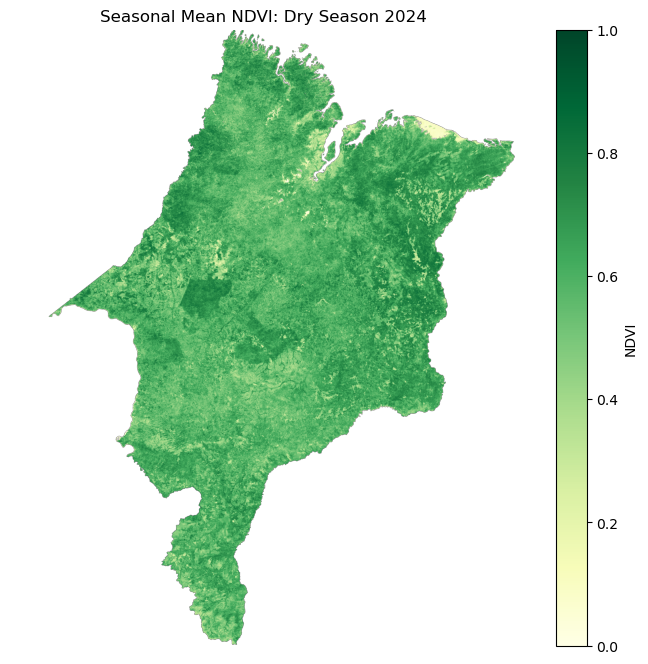

In [6]:
#More exploratory analysis -- creates map of mean NDVI for season/year of interest
import rasterio
import os
from datetime import datetime, timedelta
import numpy as np

ndvi_dir = "maranhao_annual_ndvi_reproj"
viq_dir  = "maranhao_annual_vi_qual_reproj"

def band_to_date(year, band_index):
    start = datetime(year, 1, 1)
    return start + timedelta(days=16 * band_index)

def is_rainy(month): return month in [1,2,3,4,5,6]
def is_dry(month):   return month in [7,8,9,10,11,12]

def valid_from_qamask(qa_array):
    qa_int = np.nan_to_num(qa_array, nan=255).astype(np.uint16)

    reliability = qa_int & 0b11
    return (reliability == 0) | (reliability == 1)


def seasonal_mean_raster(year, season="rainy"):
    ndvi_path = os.path.join(ndvi_dir, f"NDVI_stack_{year}_reproj.tif")
    qa_path   = os.path.join(viq_dir,  f"VI_qual_stack_{year}_reproj.tif")

    with rasterio.open(ndvi_path) as ndv_ds, rasterio.open(qa_path) as qa_ds:

        profile = ndv_ds.profile
        h, w = ndv_ds.height, ndv_ds.width

        sum_arr = np.zeros((h, w), dtype="float32")
        count_arr = np.zeros((h, w), dtype="float32")

        for b in range(1, ndv_ds.count + 1):
            date = band_to_date(year, b - 1)
            month = date.month

            if season == "rainy" and not is_rainy(month):
                continue
            if season == "dry" and not is_dry(month):
                continue

            ndvi = ndv_ds.read(b).astype("float32") * 0.0001
            qa   = qa_ds.read(b)

            valid = valid_from_qamask(qa)
            ndvi[~valid] = np.nan

            good = ~np.isnan(ndvi)
            sum_arr[good] += ndvi[good]
            count_arr[good] += 1

        mean_arr = sum_arr / count_arr
        return mean_arr, profile

import matplotlib.pyplot as plt

year_to_map = 2024    
season = "dry"

mean_arr, profile = seasonal_mean_raster(year_to_map, season)

plt.figure(figsize=(10, 8))
plt.imshow(mean_arr, cmap="YlGn", vmin=0, vmax=1)  
plt.title(f"Seasonal Mean NDVI: {season.capitalize()} Season {year_to_map}")
plt.colorbar(label="NDVI")
plt.axis("off")
plt.show()


Matplotlib is building the font cache; this may take a moment.


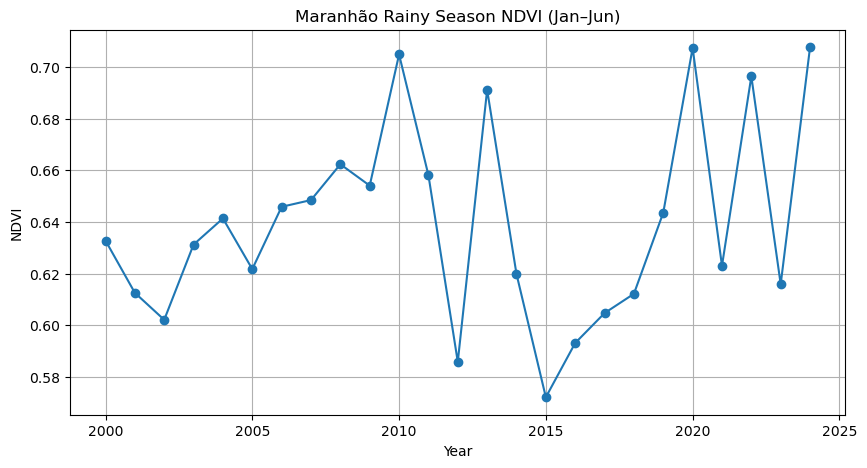

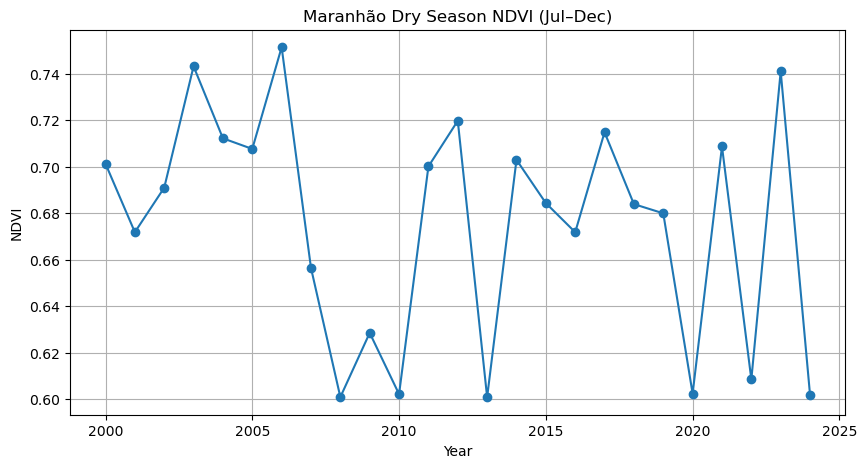

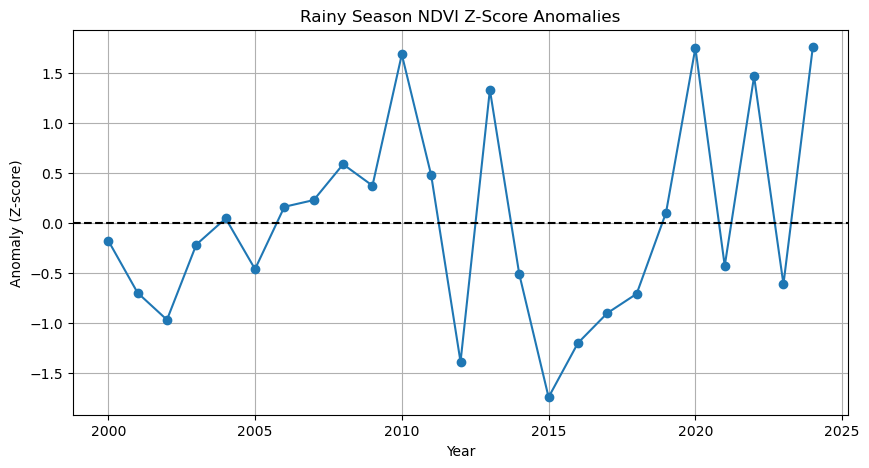

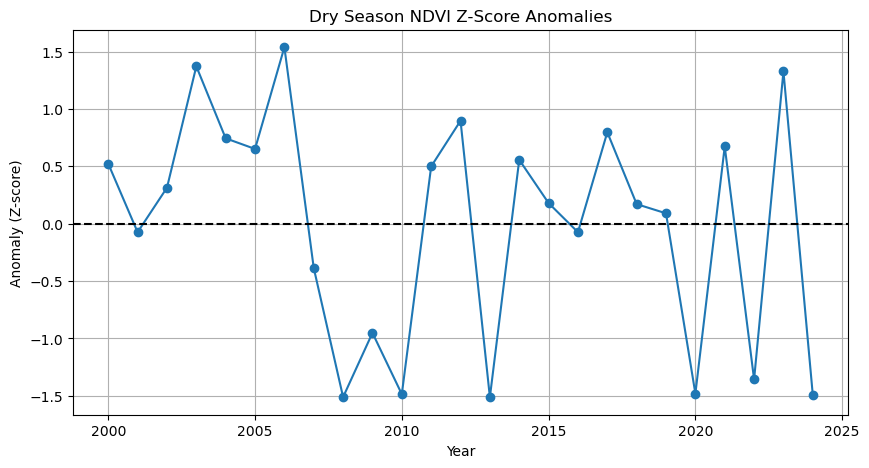

In [5]:
#Plots time series of mean NDVI and NDVI z-scores for rainy and dry seasons
import matplotlib.pyplot as plt
#Plot figures
plt.figure(figsize=(10,5))
plt.plot(df["year"], df["rainy_mean"], marker="o")
plt.title("Maranhão Rainy Season NDVI (Jan–Jun)")
plt.xlabel("Year")
plt.ylabel("NDVI")
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df["year"], df["dry_mean"], marker="o")
plt.title("Maranhão Dry Season NDVI (Jul–Dec)")
plt.xlabel("Year")
plt.ylabel("NDVI")
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df["year"], df["rainy_anomaly"], marker="o")
plt.axhline(0, color="black", linestyle="--")
plt.title("Rainy Season NDVI Z-Score Anomalies")
plt.xlabel("Year")
plt.ylabel("Anomaly (Z-score)")
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df["year"], df["dry_anomaly"], marker="o")
plt.axhline(0, color="black", linestyle="--")
plt.title("Dry Season NDVI Z-Score Anomalies")
plt.xlabel("Year")
plt.ylabel("Anomaly (Z-score)")
plt.grid()
plt.show()

In [1]:
#Create rasters of seasonal mean NDVI by year
import os
import numpy as np
import rasterio
from datetime import datetime, timedelta

#directories
ndvi_dir = "maranhao_annual_ndvi_reproj"
viq_dir  = "maranhao_annual_vi_qual_reproj"
out_dir  = "maranhao_seasonal_ndvi_rasters"

os.makedirs(out_dir, exist_ok=True)

years = range(2000, 2025)

#functions
def band_to_date(year, band_index):
    start = datetime(year, 1, 1)
    return start + timedelta(days=16 * band_index)

def is_rainy(month): return month in [1,2,3,4,5,6]
def is_dry(month):   return month in [7,8,9,10,11,12]

def valid_from_qamask(qa_array):
    qa_int = np.nan_to_num(qa_array, nan=255).astype(np.uint16)
    reliability = qa_int & 0b11
    return (reliability == 0) | (reliability == 1)

#processing loop
for year in years:
    print(f"Processing {year}...")

    ndvi_path = os.path.join(ndvi_dir, f"NDVI_stack_{year}_reproj.tif")
    qa_path   = os.path.join(viq_dir,  f"VI_qual_stack_{year}_reproj.tif")

    if not os.path.exists(ndvi_path) or not os.path.exists(qa_path):
        print(f"  Missing data for {year}, skipping.")
        continue

    with rasterio.open(ndvi_path) as ndv_ds, rasterio.open(qa_path) as qa_ds:

        if ndv_ds.count != qa_ds.count:
            print(f"  Band mismatch in {year}, skipping.")
            continue

        h, w = ndv_ds.height, ndv_ds.width

        rainy_sum   = np.zeros((h, w), dtype="float32")
        rainy_count = np.zeros((h, w), dtype="uint16")

        dry_sum     = np.zeros((h, w), dtype="float32")
        dry_count   = np.zeros((h, w), dtype="uint16")

        for b in range(1, ndv_ds.count + 1):
            date  = band_to_date(year, b - 1)
            month = date.month

            ndvi = ndv_ds.read(b).astype("float32") * 0.0001
            qa   = qa_ds.read(b)

            valid = valid_from_qamask(qa) & ~np.isnan(ndvi)
            if not np.any(valid):
                continue

            if is_rainy(month):
                rainy_sum[valid]   += ndvi[valid]
                rainy_count[valid] += 1
            else:
                dry_sum[valid]     += ndvi[valid]
                dry_count[valid]   += 1

        rainy_mean = np.divide(
            rainy_sum, rainy_count,
            out=np.full_like(rainy_sum, np.nan),
            where=(rainy_count > 0)
        )

        dry_mean = np.divide(
            dry_sum, dry_count,
            out=np.full_like(dry_sum, np.nan),
            where=(dry_count > 0)
        )

        profile = ndv_ds.profile.copy()
        profile.update(
            dtype="float32",
            count=1,
            nodata=np.nan,
            compress="lzw"
        )

        rainy_out = os.path.join(out_dir, f"NDVI_rainy_mean_{year}.tif")
        dry_out   = os.path.join(out_dir, f"NDVI_dry_mean_{year}.tif")

        with rasterio.open(rainy_out, "w", **profile) as dst:
            dst.write(rainy_mean.astype("float32"), 1)

        with rasterio.open(dry_out, "w", **profile) as dst:
            dst.write(dry_mean.astype("float32"), 1)

        print(f"Saved rainy & dry NDVI rasters for {year}")


Processing 2000...
Saved rainy & dry NDVI rasters for 2000
Processing 2001...
Saved rainy & dry NDVI rasters for 2001
Processing 2002...
Saved rainy & dry NDVI rasters for 2002
Processing 2003...
Saved rainy & dry NDVI rasters for 2003
Processing 2004...
Saved rainy & dry NDVI rasters for 2004
Processing 2005...
Saved rainy & dry NDVI rasters for 2005
Processing 2006...
Saved rainy & dry NDVI rasters for 2006
Processing 2007...
Saved rainy & dry NDVI rasters for 2007
Processing 2008...
Saved rainy & dry NDVI rasters for 2008
Processing 2009...
Saved rainy & dry NDVI rasters for 2009
Processing 2010...
Saved rainy & dry NDVI rasters for 2010
Processing 2011...
Saved rainy & dry NDVI rasters for 2011
Processing 2012...
Saved rainy & dry NDVI rasters for 2012
Processing 2013...
Saved rainy & dry NDVI rasters for 2013
Processing 2014...
Saved rainy & dry NDVI rasters for 2014
Processing 2015...
Saved rainy & dry NDVI rasters for 2015
Processing 2016...
Saved rainy & dry NDVI rasters for 20